In [1]:
from sims_pars.fitting.base import AbsObjectiveSimBased
from sims_pars import bayes_net_from_script
import scipy.stats as sts

In [2]:
class TestCase(AbsObjectiveSimBased):
    def __init__(self, mu, n=10):
        bn = bayes_net_from_script('''
        PCore Normal2 {
            mu1 ~ norm(0, 1)
            mu2 ~ norm(0, 1)
            sd ~ gamma(0.1, 0.1)
        }
        ''')
        AbsObjectiveSimBased.__init__(self, bn)
        self.Mu = mu
        self.N = n
        self.X1 = sts.norm(self.Mu[0], 1).rvs(n)
        self.X2 = sts.norm(self.Mu[1], 1).rvs(n)

    def simulate(self, pars):
        
        sts.norm(pars['mu2'], pars['sd']).rvs(n)
        
        return {
            'mu1': sts.norm(pars['mu1'], pars['sd']).rvs(10).mean(),
            'mu2': sts.norm(pars['mu2'], pars['sd']).rvs(10).mean()
        }

    def link_likelihood(self, sim):
        return sts.norm.logpdf(self.X1, sim['mu1'], 1).sum() + sts.norm.logpdf(self.X2, sim['mu2'], 1).sum()

model = TestCase([10, -5])
    
    
print('Free parameters: ', model.FreeParameters)



Free parameters:  ['mu1', 'mu2', 'sd']


## Read Model Info

## 

In [4]:
model.Domain

[Domain(Name='mu1', Type='Double', Lower=-inf, Upper=inf),
 Domain(Name='mu2', Type='Double', Lower=-inf, Upper=inf),
 Domain(Name='sd', Type='Double', Lower=0.0, Upper=inf)]

## Transformation

In [5]:
from sims_pars.fitting.hme.converter import *
import numpy as np

In [8]:
converters = get_converters(model.Domain)
converters

In [9]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

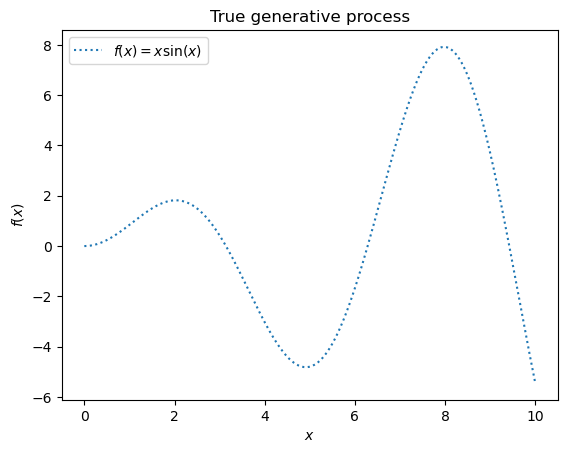

In [10]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [11]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)


5.02**2 * RBF(length_scale=1.43)

In [18]:
from abc import ABCMeta, abstractmethod

class AbsEmulator(metaclass=ABCMeta):
    def __init__(self, output, kernel=None, **kwargs):
        self.Output = output
        if kernel is None:
            self.Kernel = gpflow.kernels.RBF()
        else:
            self.Kernel = kernel
        self.Opt = dict(kwargs)
        self.GP = None

    @abstractmethod
    def train(self, xs, ys) -> None:
        pass

    @abstractmethod
    def predict(self, xs) -> tuple[np.ndarray, np.ndarray]:
        pass
    
    
class GPREmulator(AbsEmulator):
    def train(self, xs, ys):
        ys = np.array([[y[self.Output]] for y in ys])
        self.GP = gpflow.models.GPR(data=(xs, ys), kernel=self.Kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.GP.training_loss, self.GP.trainable_variables, options=self.Opt)

    def predict(self, xs) -> tuple[list, list]:
        assert self.GP is not None

        mean, var = self.GP.predict_f(xs)
        mean, var = mean.numpy(), var.numpy()
        # mean = [{self.Output: mean[i]} for i in range(n_sample)]
        # var = [{self.Output: var[i]} for i in range(n_sample)]
        return mean, var

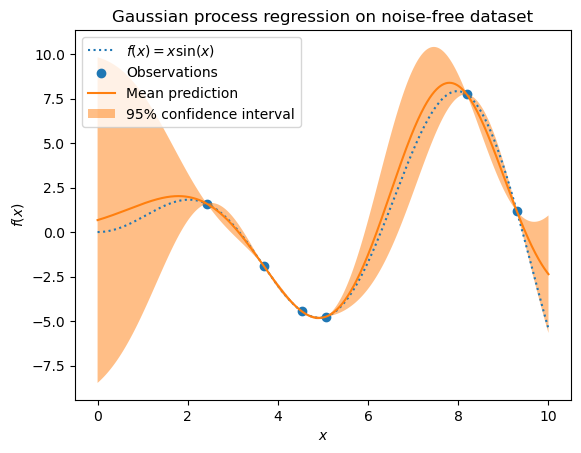

In [13]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")